In [26]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# Visual Hull

In [27]:
# Pick dataset
data_set = 'templeSR'

image_paths = {
    'dinoSR': 'dinoSparseRing/',
    'dinoR': 'dinoRing/',
    'templeSR': 'templeSparseRing/'
}

image_path = image_paths[data_set]
T = 20 # threshold to get object silhouette

fp = open(image_path+data_set+'_par.txt', 'r')  

num_images = int(fp.readline())

M = []
imgs = []
silhouettes = []
camera_positions = []
for i in xrange(num_images):
    raw_info = fp.readline().split()
    img_name = raw_info[0]
    raw_info = map(float, raw_info[1:])
    
    # Projection Matrix of the camera
    K = np.array(raw_info[0:9]).reshape(3,3)
    R = np.array(raw_info[9:18]).reshape(3,3)
    t = np.array(raw_info[18:])
    Rt = np.stack((R[:,0], R[:,1], R[:,2], t), axis=1)
    M.append(np.matmul(K, Rt))
    camera_positions.append(t)
    
    # Read Image
    img = plt.imread(image_path+img_name)
    img = img * 255
    imgs.append(img)
    
    # Compute Silhouttes
    silhouette = np.zeros((img.shape[0], img.shape[1]))
    silhouette[np.where(img > T)[:2]] = 1
    silhouettes.append(silhouette)

M = np.array(M)
imgs = np.array(imgs)
silhouettes = np.array(silhouettes)
camera_positions = np.array(camera_positions)

In [28]:
# Create a voxel grid
voxel_size = np.array([0.002, 0.002, 0.002])

bounding_boxes = {
    'dinoSR': {
        'x': np.array([-0.07, 0.02]),
        'y': np.array([-0.02, 0.07]),
        'z': np.array([-0.07, 0.02])
    },
    'dinoR': {
        'x': np.array([-0.03, 0.06]),
        'y': np.array([-0.022, 0.11]),
        'z': np.array([-0.02, 0.06])
    },
    'templeSR': {
        'x': np.array([-0.08, 0.03]),
        'y': np.array([0.0, 0.18]),
        'z': np.array([-0.02, 0.06])
    }
}

xlim = bounding_boxes[data_set]['x']
ylim = bounding_boxes[data_set]['y']
zlim = bounding_boxes[data_set]['z']

def InitializeVoxels(xlim, ylim, zlim, voxel_size):
    voxels_number = np.zeros(3)
    voxels_number[0] = abs(xlim[1] - xlim[0])/voxel_size[0]
    voxels_number[1] = abs(ylim[1] - ylim[0])/voxel_size[1]
    voxels_number[2] = abs(zlim[1] - zlim[0])/voxel_size[2]
    voxels_number_act = voxels_number + np.ones(3)
    total_number = np.prod(voxels_number_act)
    
    voxel = np.ones((int(total_number), 4), float)
    
    sx = xlim[0]
    ex = xlim[1]
    sy = ylim[0]
    ey = ylim[1]
    sz = zlim[0]
    ez = zlim[1]
    
    if ex > sx:
        x_step = voxel_size[0]
    else:
        x_step = -voxel_size[0]
        
    if ey > sy:
        y_step = voxel_size[1]
    else:
        y_step = -voxel_size[1]
    
    if ez > sz:
        z_step = voxel_size[2]
    else:
        z_step = -voxel_size[2]
    
    x_lin = np.linspace(sx, ex, int(voxels_number_act[0]))
    y_lin = np.linspace(sy, ey, int(voxels_number_act[1]))
    z_lin = np.linspace(sz, ez, int(voxels_number_act[2]))
    
    
    voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(x_lin, y_lin, z_lin)
    
    
    l = 0;
    for z in z_lin:
        for x in x_lin:
            for y in y_lin:
                voxel[l, 0:3] = np.array([x, y, z])
                l = l+1 
    return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number


voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size)

In [29]:
# Project Voxel to silhouette

def CreateVisualHull(silhouettes, voxels, M, display_projected_voxels):
    object_points3D_homo = np.transpose(voxels)
    
    voxels[:, 3] = np.ones(voxels.shape[0])

    print "frames: ",
    for i,m in enumerate(M):
        print i+1, " ",
        
        points2D_homo = np.matmul(m, object_points3D_homo)
        inf_ind = np.where(points2D_homo[2] == 0)
        points2D_homo[:, inf_ind] = 1
        
        points2D = np.divide(points2D_homo[0:2], [points2D_homo[2], points2D_homo[2]]);
        
        img_height = silhouettes.shape[1]
        img_width = silhouettes.shape[2]
        
        ind_x_lt_0 = np.where(points2D[0] < 0)
        ind_y_lt_0 = np.where(points2D[1] < 0)
        ind_x_gt_w = np.where(points2D[0] >= img_width)
        ind_y_gt_h = np.where(points2D[1] >= img_height)

        points2D[:, ind_x_lt_0] = 1
        points2D[:, ind_y_lt_0] = 1
        points2D[:, ind_x_gt_w] = 1
        points2D[:, ind_y_gt_h] = 1
        
        ind = np.ravel_multi_index((points2D[1,:].astype(int), points2D[0,:].astype(int)), dims=(img_height, img_width), order='C')
        cur_silhouette = silhouettes[i]
        img_val = cur_silhouette.ravel()[ind]
        zero_ind = np.where(img_val == 0)[0]
        voxels[zero_ind, 3] = 0
        
    return voxels

display_projected_pixels = 0;
voxels_list = CreateVisualHull(silhouettes, voxels, M, 0);

frames:  1   2   3   4   5   6   7   8   9   10   11   12   13   14   15   16  


In [30]:
def ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxel):
    sx = -(voxels_number[0]/2)*voxel_size[0]
    ex = voxels_number[0]/2*voxel_size[0]

    sy = -(voxels_number[1]/2)*voxel_size[1]
    ey = voxels_number[1]/2*voxel_size[1]

    sz = 0
    ez = voxels_number[2]*voxel_size[2]
    
    voxels_number = voxels_number+1
    voxel3D = np.zeros([int(voxels_number[1]), int(voxels_number[0]), int(voxels_number[2])])
    
    l=0
    for zi, z in enumerate(np.linspace(sz,ez,int(voxels_number[2]))):
        for xi, x in enumerate(np.linspace(sx, ex, int(voxels_number[0]))):
            for yi, y in enumerate(np.linspace(sy, ey, int(voxels_number[1]))):
                voxel3D[yi, xi, zi] = voxel[l, 3]
                l = l+1
    return voxel3D

voxel3D = ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxels_list)

In [31]:
print "Voxel 2D list"
print "Voxels list shape: ", voxels_list.shape
print "Unique values and counts: ", np.unique(voxels_list[:,3], return_counts = True)

Voxel 2D list
Voxels list shape:  (208936, 4)
Unique values and counts:  (array([0., 1.]), array([156287,  52649]))


In [32]:
print "Voxel 3D"
print "Voxels3D shape: ", voxel3D.shape

Voxel 3D
Voxels3D shape:  (91, 56, 41)


# Plotting Visual Hull (normal way)

<IPython.core.display.Javascript object>


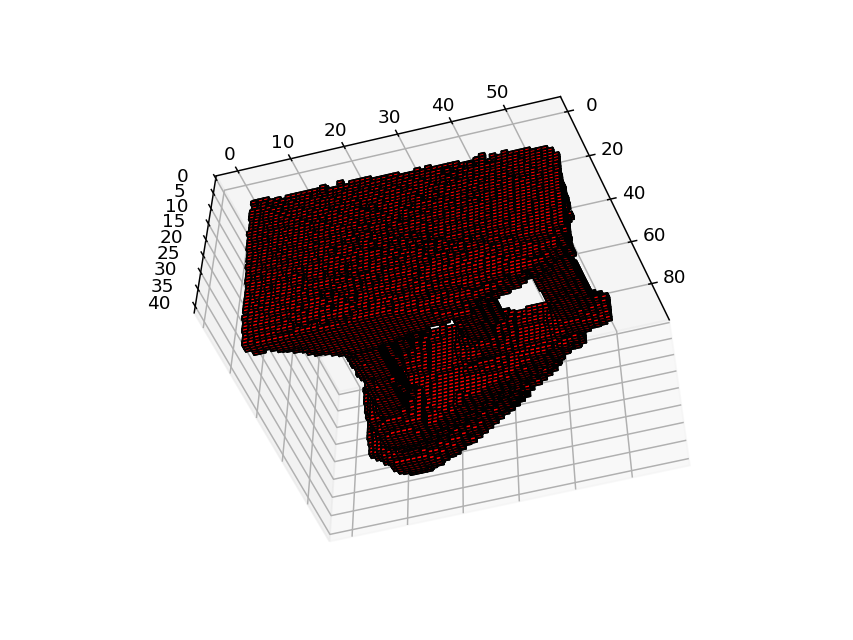

In [33]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxel3D, facecolors='red', edgecolor='k')

plt.show()

# Plotting Visual Hull (Marching Cubes)

<IPython.core.display.Javascript object>


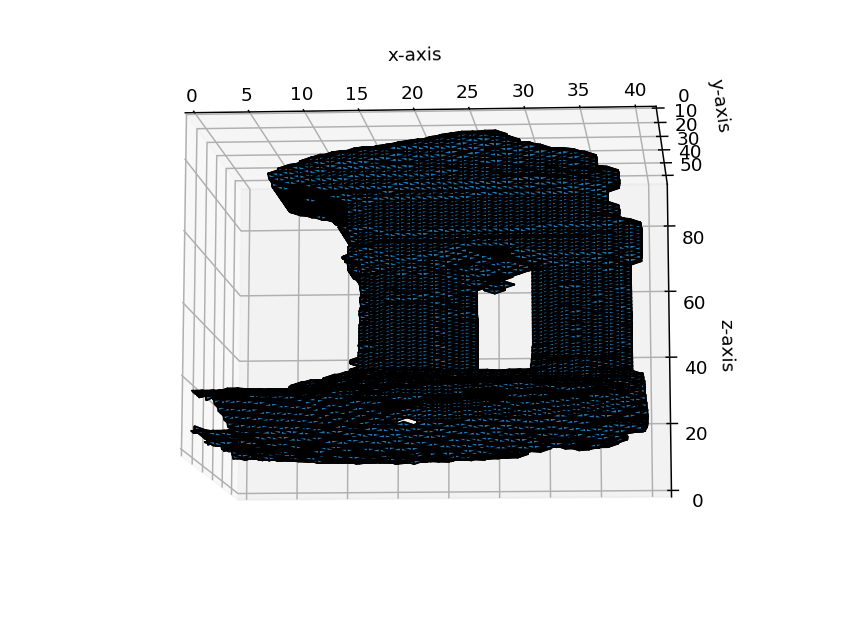

In [34]:
## Marching Cubes

from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_marching_cube(voxels):
    # Display resulting triangular mesh using Matplotlib.
    verts, faces, normals, values = measure.marching_cubes_lewiner(voxels.T, 0)

    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces])
    mesh.set_edgecolor('k')
    ax.add_collection3d(mesh)

    ax.set_xlabel("x-axis")
    ax.set_ylabel("y-axis")
    ax.set_zlabel("z-axis")

    ax.set_xlim(0, voxels.T.shape[0]) # a = 6 (times two for 2nd ellipsoid)
    ax.set_ylim(0, voxels.T.shape[1]) # b = 10
    ax.set_zlim(0, voxels.T.shape[2]) # c = 16

    plt.tight_layout()
    plt.show()



plot_marching_cube(voxel3D)

# Construct Graph

In [56]:
def CreateVoxelSurface(voxel3D):
    voxelSurf = np.zeros(voxel3D.shape)
    for y in xrange(voxel3D.shape[0]):
        for x in xrange(voxel3D.shape[1]):
            for z in xrange(voxel3D.shape[2]):
                if voxel3D[y,x,z] == 1:
                    voxelSurf[y,x,z] = voxel3D[y,x,z]
                    if x > 0 and x < voxel3D.shape[1]-1 and (voxel3D[y, x-1, z] == 0 or voxel3D[y, x+1, z] == 0):
                        voxelSurf[y,x,z] = 2
                    if y > 0 and y < voxel3D.shape[0]-1 and (voxel3D[y-1, x, z] == 0 or voxel3D[y+1, x, z] == 0):
                        voxelSurf[y,x,z] = 2
                    if z > 0 and z < voxel3D.shape[2]-1 and (voxel3D[y, x, z-1] == 0 or voxel3D[y, x, z+1] == 0):
                        voxelSurf[y,x,z] = 2
    return voxelSurf

vs = CreateVoxelSurface(voxel3D)

print np.unique(vs, return_counts=True)

def CreateGraph(visualHull, M=3, el=10, h=0.1, origin=[0,0,0], _lambda=1):
    # M: closest cameras
    # el: lambda value
    # h: size of voxel
    # origin: What the index [0,0,0] in the voxel grid corresponds to in 3D coordinate system
    
    # Create graph
    graph = maxflow.GraphFloat()
    
    # Create all nodes
    node_ids = graph.add_grid_nodes(visual_hull.shape)

    # Create t-links from surface voxels to sink 
    hullSurf = CreateVoxelSurface(visualHull)
    surf_inds = np.where(hullSurf == 2)
    surf_inds = surf_inds[2]*hullSurf.shape[2] + surf_inds[1]*hullSurf.shape[1] + surf_inds[0]*hullSurf.shape[0]
    
    for ind in surf_inds:
        graph.add_tedge(ind, 0, float(inf))

    # Create t-links from source to all non-surface voxels
    non_surf_inds = np.where(hullSurf == 1)
    non_surf_inds = non_surf_inds[2]*hullSurf.shape[2] + non_surf_inds[1]*hullSurf.shape[1] + non_surf_inds[0]*hullSurf.shape[0]
    
    Wb = _lambda * np.prod(visualHull.shape)
    for ind in non_surf_inds:
        graph.add_tedge(ind, Wb, 0)
    
    # Create n-links using Photo Consistency
    
    
    
    
    

(array([0., 1., 2.]), array([82689, 10182,  4465]))


In [46]:
## TODO check if these are the correct coordinates for x/y/z directions
x_structure = np.zeros((3,3,3))
x_structure[1][1][2] = 1

y_structure = np.zeros((3,3,3))
y_structure[1][2][1] = 1

z_structure = np.zeros((3,3,3))
z_structure[2][1][1] = 1

def get_pixel_from_3D(camera, coordinate):
    #TODO millin probably has this
    pass

def get_M_closest_cameras(coordinate, M):
    d = [None for _ in range(len(camera_positions))]
    for i in range(len(camera_positions)):
        d[i] = np.norm(coordinate-camera_positions[i])
    sorted_d = sorted(range(len(d)), key=lambda k: d[k])
    return sorted_d[:M]

def create_edge_weights(visual_hull):
    #NOTE: this function isn't used yet but could be an optimization later
    x_plus = np.zeros(visual_hull.shape)
    y_plus = np.zeros(visual_hull.shape)
    z_plus = np.zeros(visual_hull.shape)
    
    hull_indices = np.where(visual_hull > 0)
    
    x_plus[hull_indices] = list_of_weights
    
    
def get_variance(pixels):
    ave_R = sum(pixels[:,0])/len(pixels[:,0])
    ave_G = sum(pixels[:,1])/len(pixels[:,1])
    ave_B = sum(pixels[:,2])/len(pixels[:,2])
    ave_pixel = np.array([ave_R, ave_G, ave_B])
    variance = 0
    for i in range(len(pixels)):
        variance += np.norm(pixels[i]-ave_pixel)**2
    return variance

def is_edge(visual_hull, index):
    x,y,z = visual_hull.shape
    if index[0] == 0 || index[1] == 0 || index[2] == 0:
        return True
    if index[0]+1 == x || index[1]+1 == y || index[2]+1 == z:
        return True
    neighbours = []
    index = np.array(index)
    neighbours.append(index + np.array([1,0,0]))
    neighbours.append(index + np.array([-1,0,0]))
    neighbours.append(index + np.array([0,1,0]))
    neighbours.append(index + np.array([0,-1,0]))
    neighbours.append(index + np.array([0,0,1]))
    neighbours.append(index + np.array([0,0,-1]))
    
    for n in neighbours:
        if visual_hull[n[0],n[1],n[2]] == 0:
            return True
        
    return False
    

    
def CreateGraph(visual_hull, M=3, el=10, h=0.1, origin=[0,0,0]):
    # M: closest cameras
    # el: lambda value
    # h: size of voxel
    # origin: What the index [0,0,0] in the voxel grid corresponds to in 3D coordinate system
    
    graph = maxflow.GraphFloat()
    node_ids = graph.add_grid_nodes(visual_hull.shape)
    hull_indices = np.where(visual_hull > 0)
    valid_node_ids = node_ids[hull_indices]

    hull_coords = np.array([hull_indices[0]*h + origin[0], hull_indices[1]*h + origin[1], hull_indices[2]*h + origin[2]])
    
    
#     edge_coordinates = []
#     edge_coordinates.append(np.array([hull_coords[0]+0.5*h,hull_coords[1],hull_coords[2]]))
#    # edge_coordinates.append(np.array([hull_coords[0]-0.5*h,hull_coords[1],hull_coords[2]]))
#     edge_coordinates.append(np.array([hull_coords[0],hull_coords[1]+0.5*h,hull_coords[2]]))
#    # edge_coordinates.append(np.array([hull_coords[0],hull_coords[1]-0.5*h,hull_coords[2]]))
#     edge_coordinates.append(np.array([hull_coords[0],hull_coords[1],hull_coords[2]+0.5*h]))
   # edge_coordinates.append(np.array([hull_coords[0],hull_coords[1],hull_coords[2]-0.5*h]))
    
    
    # Indices of the 6 neighbouring nodes for each visual hull node
#     edge_indices = []
#     edge_indices.append(np.array([hull_indices[0]+1,hull_indices[1],hull_indices[2]]))
#     edge_indices.append(np.array([hull_indices[0]-1,hull_indices[1],hull_indices[2]]))
#     edge_indices.append(np.array([hull_indices[0],hull_indices[1]+1,hull_indices[2]]))
#     edge_indices.append(np.array([hull_indices[0],hull_indices[1]-1,hull_indices[2]]))
#     edge_indices.append(np.array([hull_indices[0],hull_indices[1],hull_indices[2]+1]))
#     edge_indices.append(np.array([hull_indices[0],hull_indices[1],hull_indices[2]-1]))
    
    for i in range(len(hull_indices[0])):
        #current_index = np.array(zip(hull_indices)[i])
        current_index = np.array([hull_indices[0][i],hull_indices[1][i],hull_indices[2][i]])
        #coordinate = np.array(zip(hull_coords)[i])
        coordinate = np.array([hull_coords[0][i],hull_coords[1][i],hull_coords[2][i]])
        closest_cameras = get_M_closest_cameras(coordinate,M)
        node_id = valid_node_ids[i]
        
        x_coord = coordinate + np.array([0.5*h, 0, 0])
        y_coord = coordinate + np.array([0, 0.5*h, 0])
        z_coord = coordinate + np.array([0, 0, 0.5*h])
        
        pixels_x = []
        pixels_y = []
        pixels_z = []
        for camera in closest_cameras:
            pixels_x.append(get_pixel_from_3D(camera, x_coord))
            pixels_y.append(get_pixel_from_3D(camera, y_coord))
            pixels_z.append(get_pixel_from_3D(camera, z_coord))
        
        x_weight = get_variance(pixels_x)
        y_weight = get_variance(pixels_y)
        z_weight = get_variance(pixels_z)

        # TODO maybe check if the edge is being connected to a node not in the visual hull; i.e. don't add that edge
        
        # N-Links
        graph.add_grid_edges(np.array([node_id]), weights=np.array([x_weight]), structure=x_structure, symmetric=True)
        graph.add_grid_edges(np.array([node_id]), weights=np.array([y_weight]), structure=y_structure, symmetric=True)
        graph.add_grid_edges(np.array([node_id]), weights=np.array([z_weight]), structure=z_structure, symmetric=True)
        
        
        # Source Link
        if is_edge(visual_hull, current_index):
            graph.add_tedge(node_id, el*(h**3), 999999999)
        else:
            graph.add_tedge(node_id, el*(h**3), 0)
        
    return graph, node_ids
    
    
def run_maxflow(graph, node_ids):
    maxflow_value = graph.maxflow()
    segments = graph.get_grid_segments(node_ids)
    return maxflow_value, segments
    
    
    

SyntaxError: invalid syntax (<ipython-input-46-c8a7179c83f3>, line 45)

In [52]:
def CreateSurfaceVoxel(voxel3D):
    voxelSurf = np.zeros(voxel3D.shape)
    for y in xrange(voxel3D.shape[0]):
        for x in xrange(voxel3D.shape[1]):
            for z in xrange(voxel3D.shape[2]):
                if voxel3D[y,x,z] == 1:
                    if x > 0 and x < voxel3D.shape[1]-1 and (voxel3D[y, x-1, z] == 0 or voxel3D[y, x+1, z] == 0):
                        voxelSurf[y,x,z] = 1
                    if y > 0 and y < voxel3D.shape[0]-1 and (voxel3D[y-1, x, z] == 0 or voxel3D[y+1, x, z] == 0):
                        voxelSurf[y,x,z] = 1
                    if z > 0 and z < voxel3D.shape[2]-1 and (voxel3D[y, x, z-1] == 0 or voxel3D[y, x, z+1] == 0):
                        voxelSurf[y,x,z] = 1
    return voxelSurf

voxelSurf = CreateSurfaceVoxel(voxel3D)
print np.unique(voxelSurf, return_counts=True)

(array([0., 1.]), array([92871,  4465]))


<IPython.core.display.Javascript object>


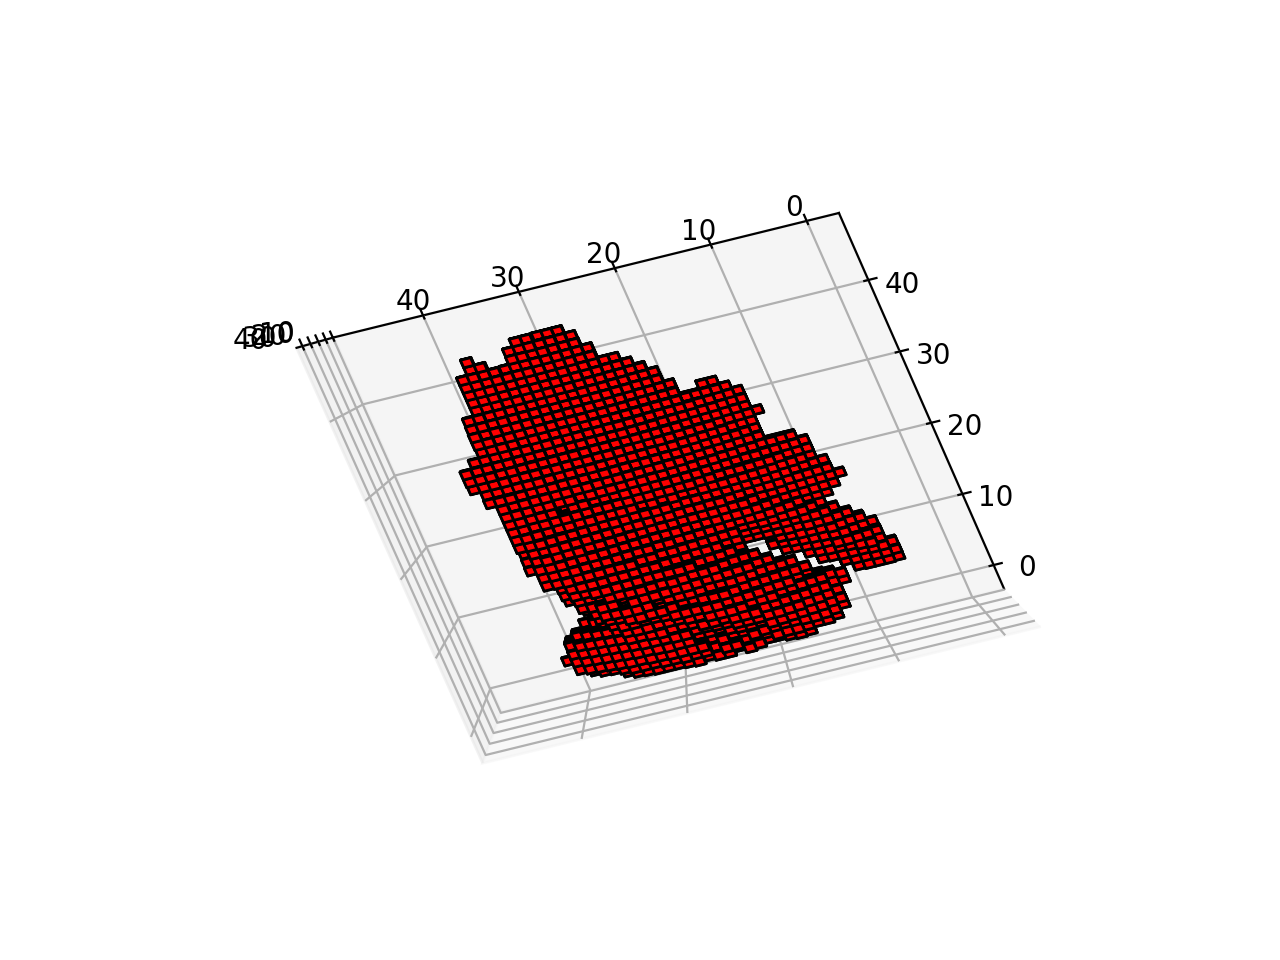

In [57]:
np.prod(voxel3D.shape)

97336

In [58]:
voxel3D.shape

(46, 46, 46)